#***Data Processing***

In [2]:
import numpy as np
import pandas as pd
import os
import glob
import random
from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
vehicle_data_path = "/content/drive/MyDrive/NativeCarDataset"
os.listdir(vehicle_data_path)

['test', 'train']

In [5]:
paths_train=glob.glob(os.path.join(vehicle_data_path,'train/*/*','*.jpg'))
paths_train_xml=glob.glob(os.path.join(vehicle_data_path,'train/*/*','*.xml'))

paths_test=glob.glob(os.path.join(vehicle_data_path,'test/*/*','*.jpg'))
paths_test_xml=glob.glob(os.path.join(vehicle_data_path,'test/*/*','*.xml'))

len(paths_train), len(paths_train_xml), len(paths_test),len(paths_test_xml)

(5863, 5874, 1471, 1476)

#***Image Classification***

In [6]:
import tensorflow as tf
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import cv2
import matplotlib.pyplot as plt
from keras.layers import Input, Lambda, Dense, Flatten

In [7]:
IMAGE_SIZE = [224, 224]

In [8]:
vgg = VGG16(input_shape=IMAGE_SIZE +[3], weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [9]:
for layer in vgg.layers:
    layer.trainable=False

In [10]:
folders = glob.glob(os.path.join(vehicle_data_path,'train/*'))

In [11]:
x= Flatten()(vgg.output)
x= Dense(64, activation= 'relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [12]:
model = Model(inputs=vgg.input, outputs=prediction)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [15]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen =ImageDataGenerator(rescale = 1./255,
                                 shear_range = 0.2,
                                 zoom_range = 0.2,
                                 horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/NativeCarDataset/train',
                                                target_size=IMAGE_SIZE,
                                                batch_size= 64,
                                                class_mode='categorical')
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/NativeCarDataset/test',
                                           target_size= IMAGE_SIZE,
                                           batch_size = 64,
                                           class_mode = 'categorical')

Found 5868 images belonging to 13 classes.
Found 1474 images belonging to 13 classes.


In [16]:
len(training_set), len(test_set)

(92, 24)

In [17]:
device_list = tf.test.gpu_device_name()
device_list

'/device:GPU:0'

In [18]:
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=30,
  steps_per_epoch=len(training_set)/2,
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
46/46 [==============================] - 3060s 66s/step - loss: 2.2248 - accuracy: 0.3043 - val_loss: 1.9002 - val_accuracy: 0.3826
Epoch 2/30
46/46 [==============================] - 1295s 28s/step - loss: 1.7790 - accuracy: 0.4073 - val_loss: 1.6659 - val_accuracy: 0.4552
Epoch 3/30
46/46 [==============================] - 900s 20s/step - loss: 1.5237 - accuracy: 0.5078 - val_loss: 1.4366 - val_accuracy: 0.5407
Epoch 4/30
46/46 [==============================] - 669s 15s/step - loss: 1.3094 - accuracy: 0.5730 - val_loss: 1.3031 - val_accuracy: 0.5760
Epoch 5/30
46/46 [==============================] - 588s 13s/step - loss: 1.1882 - accuracy: 0.6012 - val_loss: 1.2365 - val_accuracy: 0.5841
Epoch 6/30
46/46 [==============================] - 545s 12s/step - loss: 1.0735 - accuracy: 0.6409 - val_loss: 1.2548 - val_accuracy: 0.5936
Epoch 7/30
46/46 [==============================] - 511s 11s/step - loss: 1.0020 - accuracy: 0.6669 - val_loss: 1.0835 - val_accuracy: 0.6526
Epoc

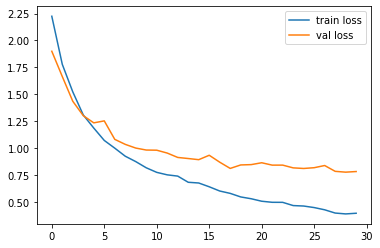

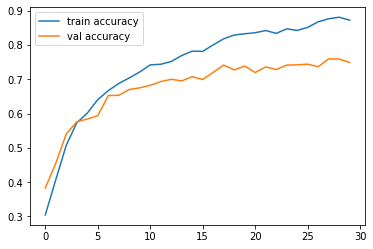

<Figure size 432x288 with 0 Axes>

In [19]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [20]:
import tensorflow as tf 
from keras.models import load_model
model.save('model_vgg16.h6')

INFO:tensorflow:Assets written to: model_vgg16.h6/assets
